In [60]:
import sys
import subprocess
python = sys.executable
subprocess.check_call(
    [python, '-m', 'pip', 'install', '--upgrade', '-r', 'requirement.txt'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT  #Suppress error messages
)

print(">>> requirements checked <<<\n")

>>> requirements checked <<<



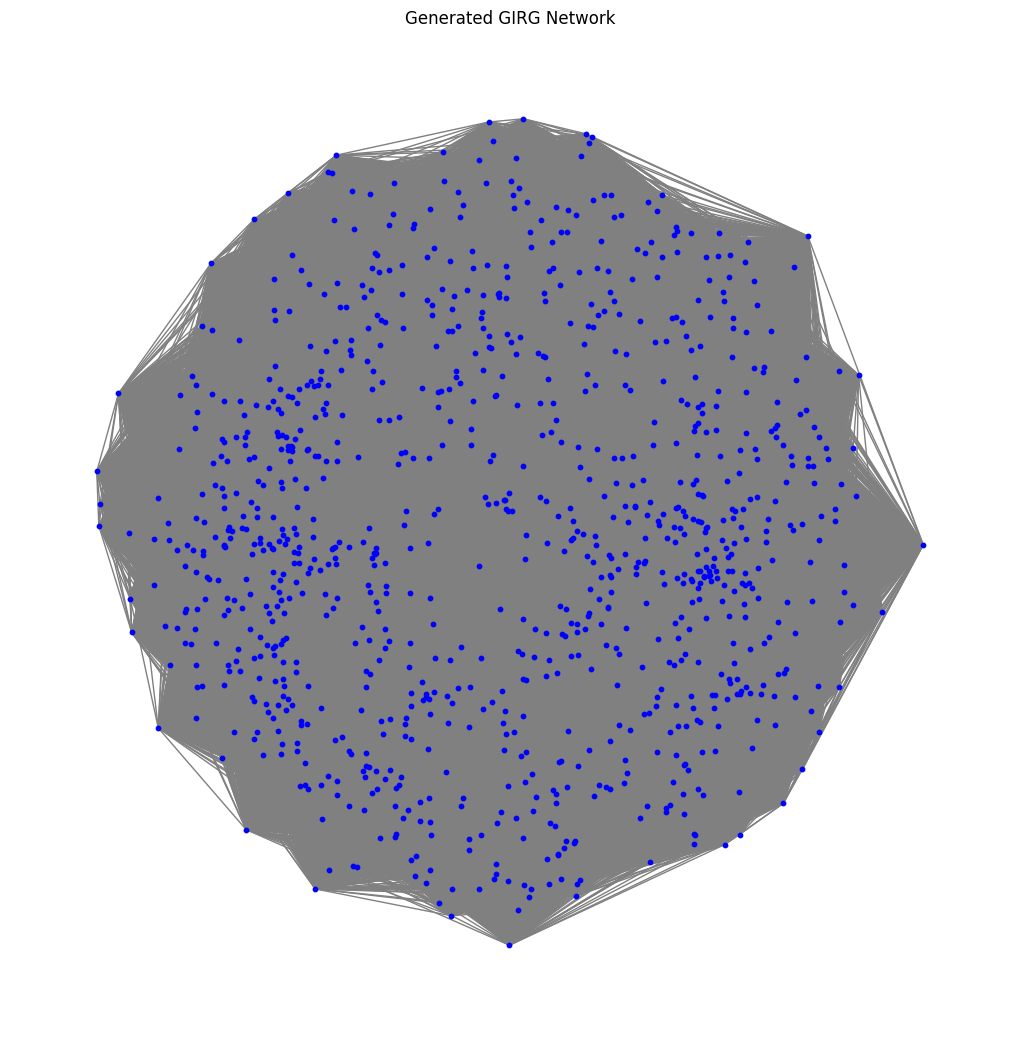

In [61]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

class GIRG:
    def __init__(self, n, d, tau, alpha, expected_weight):
        self.n = n
        self.d = d
        self.tau = tau
        self.alpha = alpha
        self.expected_weight = expected_weight
        self.positions = np.random.uniform(size=(n, d))
        self.weights = self._generate_weights(tau, expected_weight, n)
        self.graph = self._generate_graph()

    def _generate_weights(self, tau, expected_weight, size):
        return np.random.random(size)**(-1/(tau-1)) * (expected_weight) * (tau-2) / (tau-1)

    def _distance_matrix(self):
        return squareform(pdist(self.positions))

    def _generate_graph(self):
        dist_matrix = self._distance_matrix()
        graph = nx.Graph()
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if dist_matrix[i, j] == 0:
                    dist_matrix[i, j] = np.finfo(float).eps  # to avoid division by zero
                p = 1 - np.exp(- (self.weights[i] * self.weights[j]) / (dist_matrix[i, j] ** self.d) ** self.alpha)
                if np.random.random() < p:
                    graph.add_edge(i, j)
        return graph

# Example usage:
n = 1000  # number of nodes
d = 2  # dimension
tau = 2.5  # power-law exponent
alpha = 2  # distance dependence exponent
expected_weight = 1  # expected weight

G = GIRG(n, d, tau, alpha, expected_weight).graph
# Visualize the network
def visualize_network(G):
    pos = nx.spring_layout(G)  # or any other layout you prefer
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=10, node_color='blue', edge_color='gray', with_labels=False)
    plt.title("Generated GIRG Network")
    plt.show()

visualize_network(G)

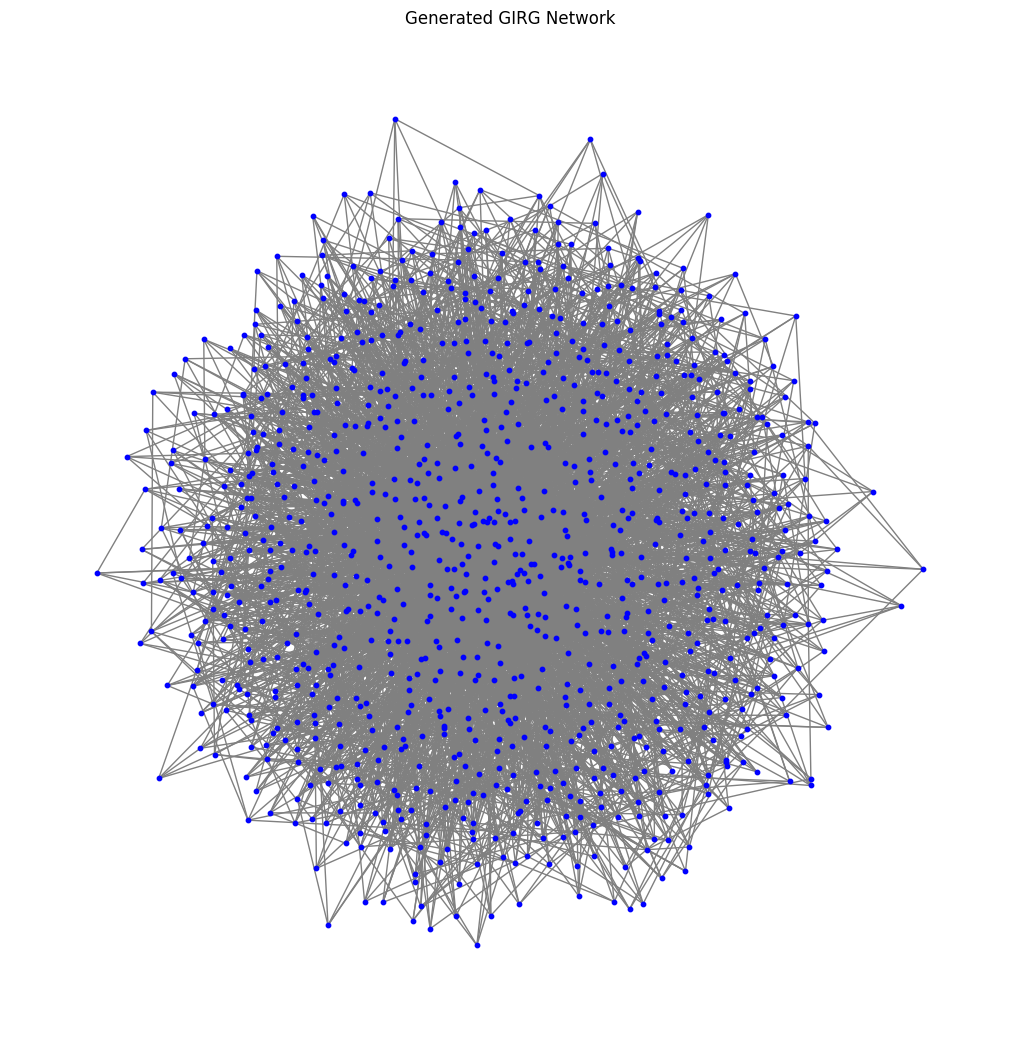

In [89]:
G = nx.barabasi_albert_graph(n, m=5)
# Visualize the network
def visualize_network(G):
    pos = nx.spring_layout(G)  # or any other layout you prefer
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=10, node_color='blue', edge_color='gray', with_labels=False)
    plt.title("Generated GIRG Network")
    plt.show()

visualize_network(G)

In [90]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from joblib import Parallel, delayed
import time

np.random.seed(42)

# UPN-SEIRD model parameters
beta_u = 0.17
beta_p = 0.05 * beta_u  # Infection rate for positive information
beta_n = 0.05 * beta_u  # Infection rate for negative information
sigma = 1 / 5
gamma = 1 / 14
f = 0.01
kappa = 1
lambda_plus = 0.1 * kappa  # Rate of becoming positive spreader
lambda_minus = 0.1 * kappa  # Rate of becoming negative spreader
delta_plus = 1 / 30
delta_minus = 1 / 30

# Initial conditions
initial_infected = 5  # Initial number of infected individuals
initial_aware = 10  # Initial number of aware individuals
t_max = 150 # Maximum time
dt = 0.05  # Time step
time_steps = np.arange(0, t_max, dt)

# Different combinations of p and q
qs = np.linspace(0, 1, 50)
ps = np.linspace(0, 1, 50)

def initialize_states(N, initial_infected, initial_aware):
    S = np.full(N, 1)  # Susceptible
    E = np.zeros(N)  # Exposed
    I = np.zeros(N)  # Infected
    R = np.zeros(N)  # Recovered
    D = np.zeros(N)  # Deceased
    U = np.full(N, 1 - initial_aware / N)  # Unaware
    P = np.zeros(N)  # Positive Spreader
    N_nodes = np.zeros(N)  # Negative Spreader

    infected_nodes = np.random.choice(np.arange(N), initial_infected, replace=False)
    aware_nodes = np.random.choice(np.arange(N), initial_aware, replace=False)

    I[infected_nodes] = 1
    U[aware_nodes] = 0
    P[aware_nodes] = 1

    return S, E, I, R, D, U, P, N_nodes

# State transition functions
def simulate_upn_seird_combined(q, p, G):
    N = len(G)
    S = np.full(N, 1)
    E = np.zeros(N)
    I = np.zeros(N)
    R = np.zeros(N)
    D = np.zeros(N)
    U = np.full(N, 1 - initial_aware / N)
    P = np.zeros(N)
    N_nodes = np.zeros(N)

    infected_nodes = np.random.choice(np.arange(N), initial_infected, replace=False)
    aware_nodes = np.random.choice(np.arange(N), initial_aware, replace=False)
    adjacency_matrix = nx.to_numpy_array(G)

    I[infected_nodes] = 1
    U[aware_nodes] = 0
    P[aware_nodes] = 1

    total = U + P + N_nodes
    U /= total
    P /= total
    N_nodes /= total

    mean_degree = np.mean([G.degree(n) for n in G.nodes])
    
    for t_index, t in enumerate(time_steps):
        sum_p = np.sum(P) / mean_degree
        sum_n = np.sum(N_nodes) / mean_degree
        sum_i = np.sum(I) / mean_degree
        
        # Calculate state change rates
        new_E = (beta_u * S * adjacency_matrix.dot(I)) * dt
        new_I = (sigma * E) * dt
        new_R = ((1 - f) * gamma * I) * dt
        new_D = (f * gamma * I) * dt
        new_P = (lambda_plus * U * adjacency_matrix.dot(P) + kappa * I * U) * dt
        new_U_from_P = (delta_plus * P) * dt
        new_N = (lambda_minus * U * adjacency_matrix.dot(N_nodes) + kappa * I * U) * dt
        new_U_from_N = (delta_minus * N_nodes) * dt
        
        # Update states
        S = np.clip(S - new_E, 0, 1)
        E = np.clip(E + new_E - new_I, 0, 1)
        I = np.clip(I + new_I - new_R - new_D, 0, 1)
        R = np.clip(R + new_R, 0, 1)
        D = np.clip(D + new_D, 0, 1)
        U = np.clip(U - new_P - new_N + new_U_from_P + new_U_from_N, 0, 1)
        P = np.clip(P + new_P - new_U_from_P, 0, 1)
        N_nodes = np.clip(N_nodes + new_N - new_U_from_N, 0, 1)
        
        # Normalize to ensure U + P + N = 1
        UPN_total = U + P + N_nodes + 1e-10  # Add epsilon to avoid division by zero
        U /= UPN_total
        P /= UPN_total
        N_nodes /= UPN_total

    return S.sum() / N, max(I), np.argmax(I) * dt

Simulation completed in 47781.06 seconds.
Plotting the results...


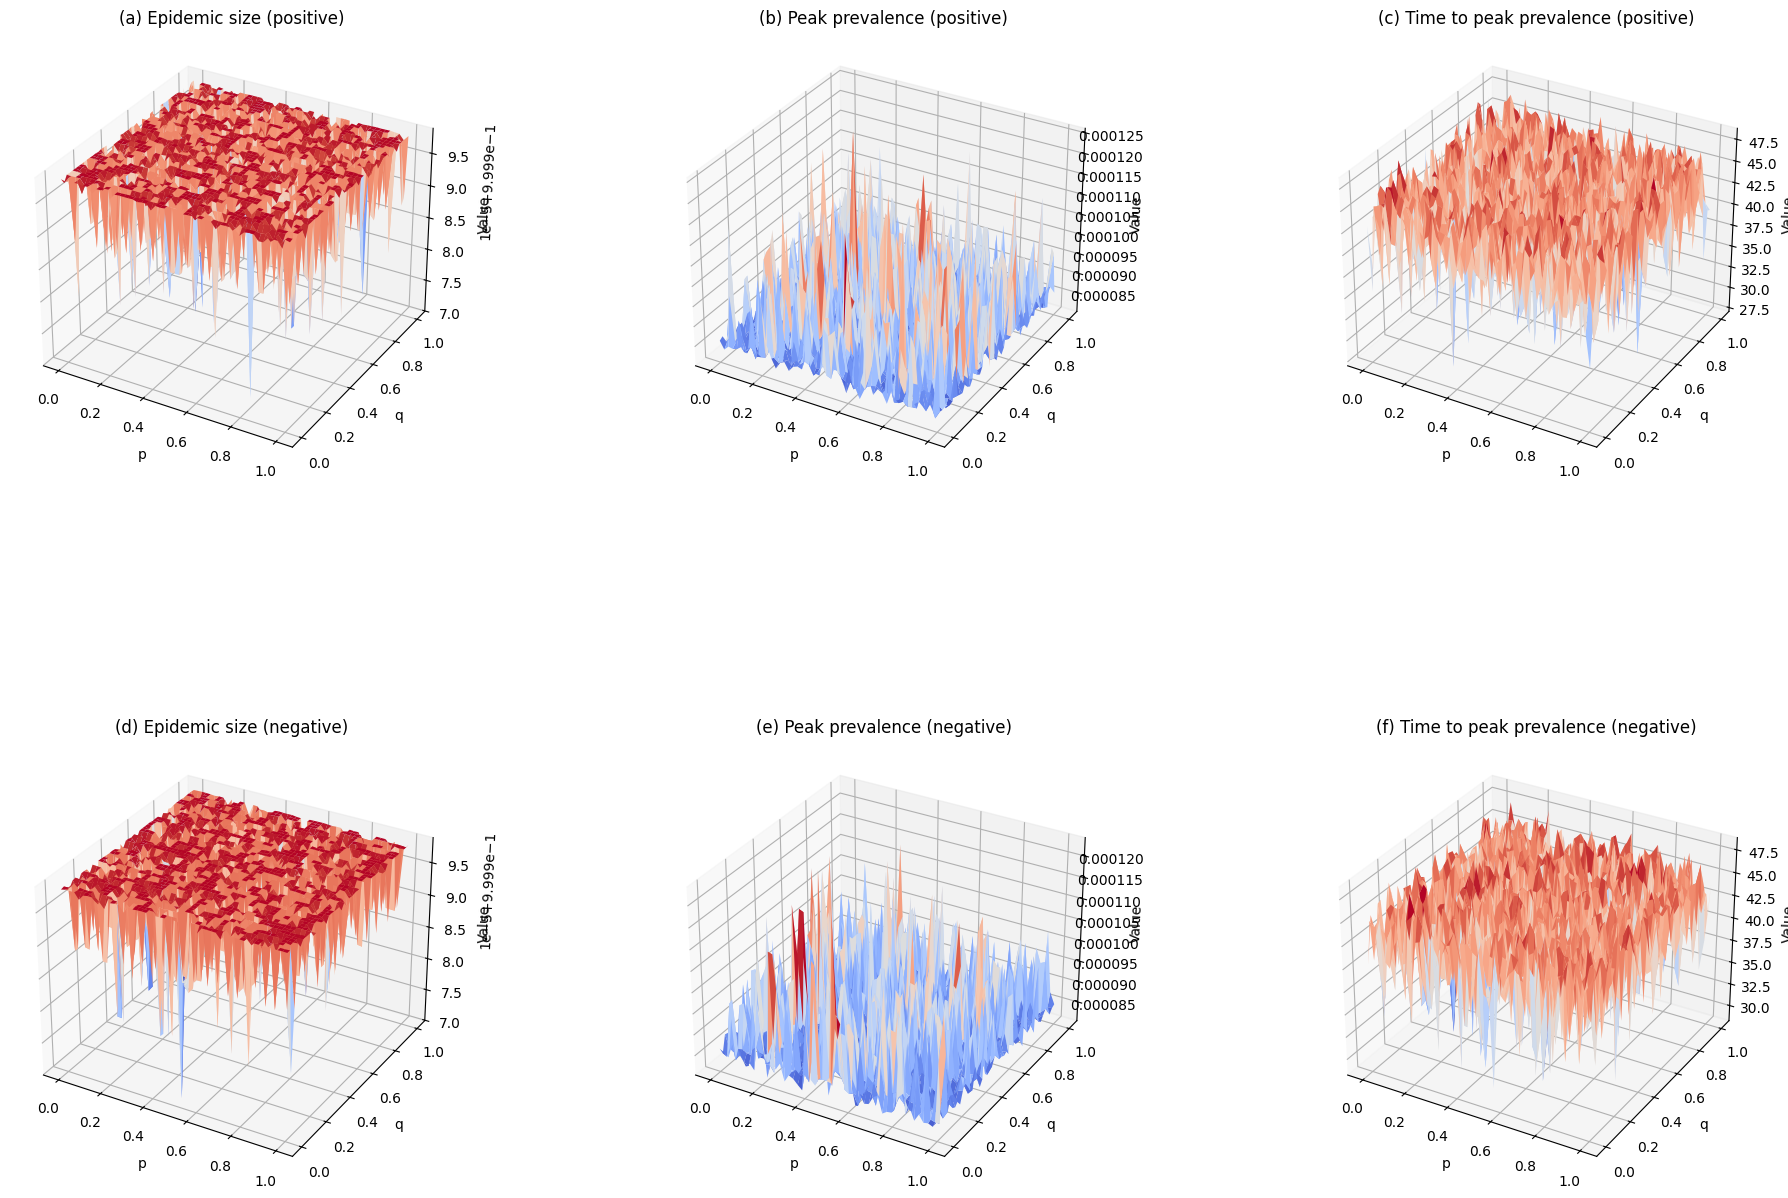

In [91]:
realizations = 10

# Function to run the simulation
def run_simulation(q, p, realization):
    print(f"Running simulation {realization+1} for q={q}, p={p}")
    G = nx.barabasi_albert_graph(n, m=5)
    return simulate_upn_seird_combined(q, p, G)

start_time = time.time()

# Run n realizations and average the results
results_pos = np.zeros((realizations, len(qs), len(ps), 3))
results_neg = np.zeros((realizations, len(qs), len(ps), 3))

for i in range(realizations):
    pos_results = Parallel(n_jobs=-1)(delayed(run_simulation)(q, p, i) for q in qs for p in ps)
    neg_results = Parallel(n_jobs=-1)(delayed(run_simulation)(q, p, i) for q in qs for p in ps)
    results_pos[i] = np.array(pos_results).reshape(len(qs), len(ps), 3)
    results_neg[i] = np.array(neg_results).reshape(len(qs), len(ps), 3)

# Average the results
mean_results_pos = results_pos.mean(axis=0)
mean_results_neg = results_neg.mean(axis=0)

end_time = time.time()
print(f"Simulation completed in {end_time - start_time:.2f} seconds.")

# Extract results
s_arr_pos, i_arr_pos, t_arr_pos = mean_results_pos[:, :, 0], mean_results_pos[:, :, 1], mean_results_pos[:, :, 2]
s_arr_neg, i_arr_neg, t_arr_neg = mean_results_neg[:, :, 0], mean_results_neg[:, :, 1], mean_results_neg[:, :, 2]

# Plotting
print("Plotting the results...")
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

Ps, Qs = np.meshgrid(ps, qs)

ax1.plot_surface(Ps, Qs, 1 - s_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax2.plot_surface(Ps, Qs, i_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax3.plot_surface(Ps, Qs, t_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax4.plot_surface(Ps, Qs, 1 - s_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax5.plot_surface(Ps, Qs, i_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax6.plot_surface(Ps, Qs, t_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_title('(a) Epidemic size (positive)')
ax2.set_title('(b) Peak prevalence (positive)')
ax3.set_title('(c) Time to peak prevalence (positive)')
ax4.set_title('(d) Epidemic size (negative)')
ax5.set_title('(e) Peak prevalence (negative)')
ax6.set_title('(f) Time to peak prevalence (negative)')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()

Plotting the results...


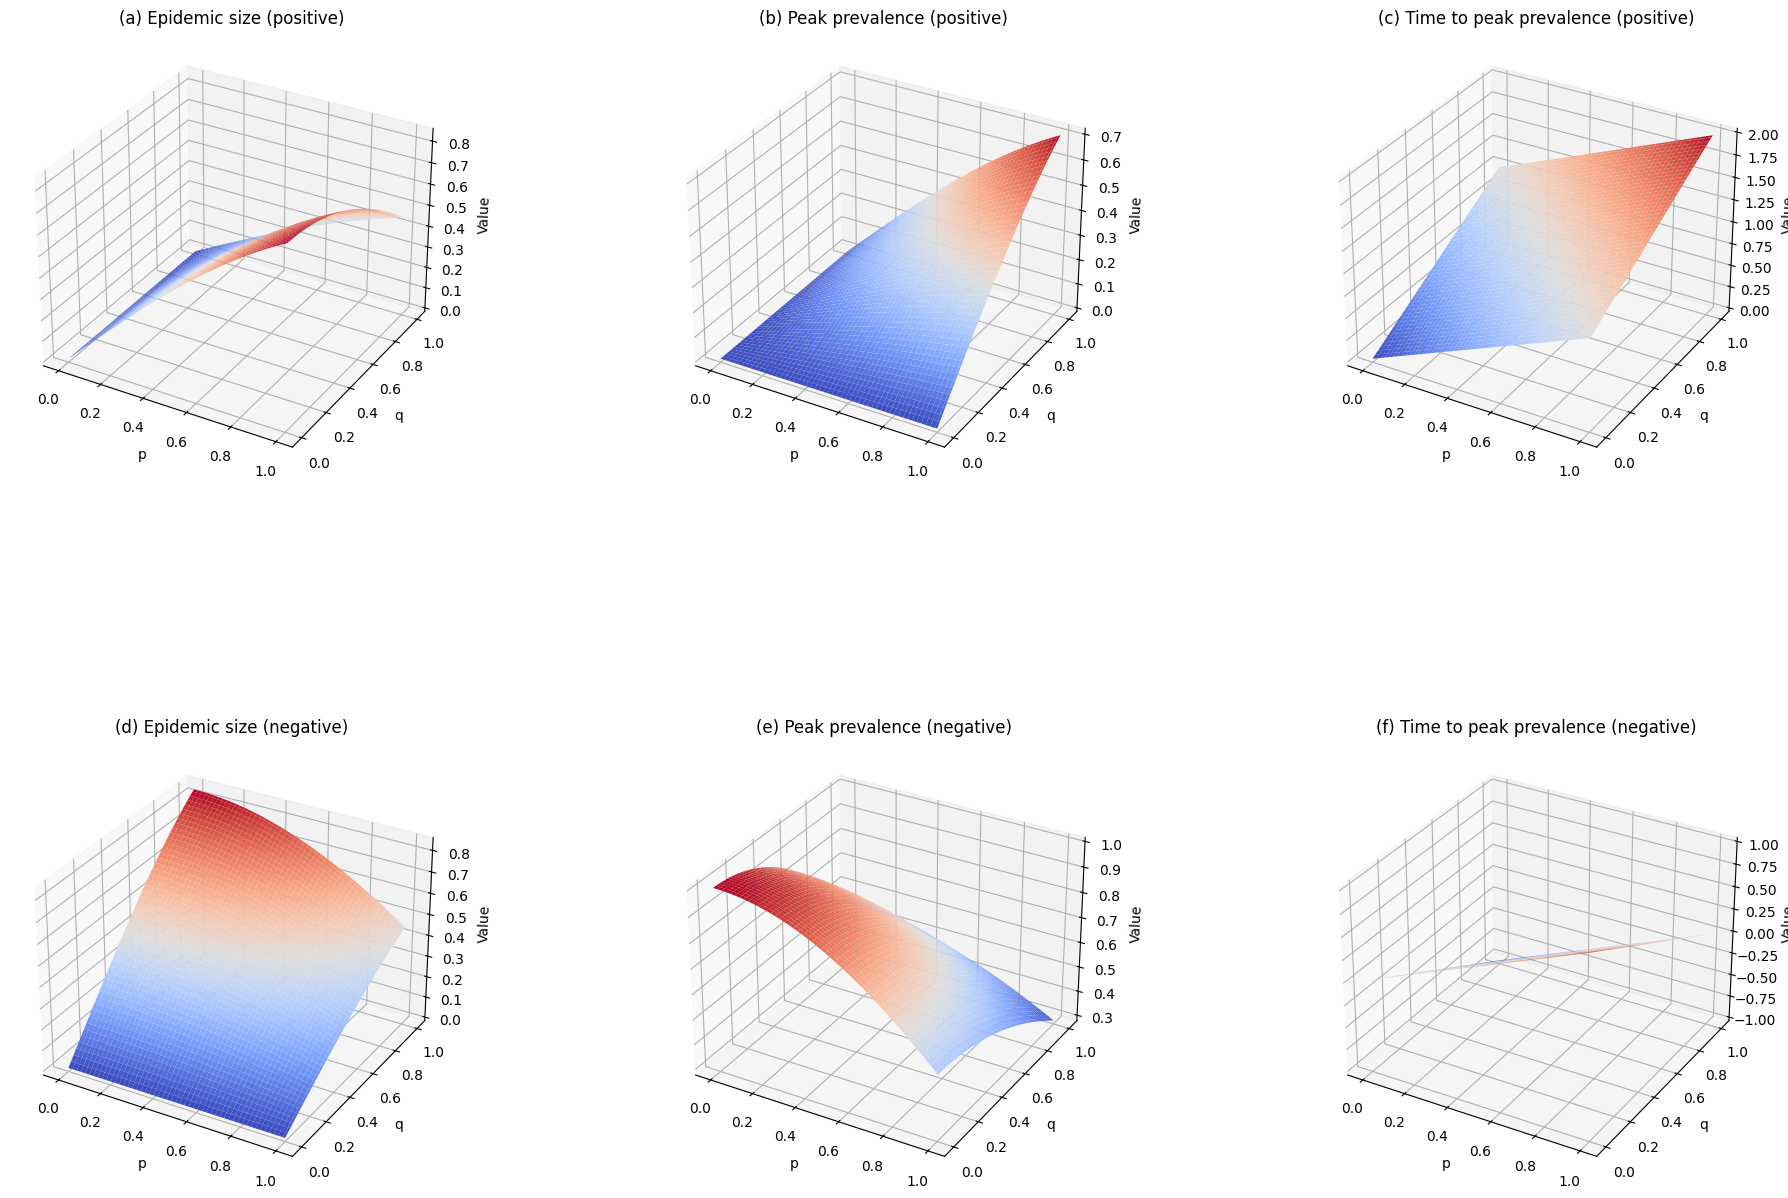

Plotting completed.


In [92]:
# hypothetical results

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Hypothetical parameters
qs = np.linspace(0, 1, 100)
ps = np.linspace(0, 1, 100)
Ps, Qs = np.meshgrid(ps, qs)

# Hypothetical results
s_arr_pos = np.sin(Ps) * np.cos(Qs)
i_arr_pos = np.sin(Ps) * np.sin(Qs)
t_arr_pos = Ps + Qs

s_arr_neg = np.cos(Ps) * np.sin(Qs)
i_arr_neg = np.cos(Ps) * np.cos(Qs)
t_arr_neg = Ps - Qs

# Plotting
print("Plotting the results...")
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

ax1.plot_surface(Ps, Qs, s_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax2.plot_surface(Ps, Qs, i_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax3.plot_surface(Ps, Qs, t_arr_pos, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax4.plot_surface(Ps, Qs, s_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax5.plot_surface(Ps, Qs, i_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax6.plot_surface(Ps, Qs, t_arr_neg, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_title('(a) Epidemic size (positive)')
ax2.set_title('(b) Peak prevalence (positive)')
ax3.set_title('(c) Time to peak prevalence (positive)')
ax4.set_title('(d) Epidemic size (negative)')
ax5.set_title('(e) Peak prevalence (negative)')
ax6.set_title('(f) Time to peak prevalence (negative)')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()
print("Plotting completed.")